## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
%matplotlib inline

from moviepy.editor import VideoFileClip
from IPython.display import HTML

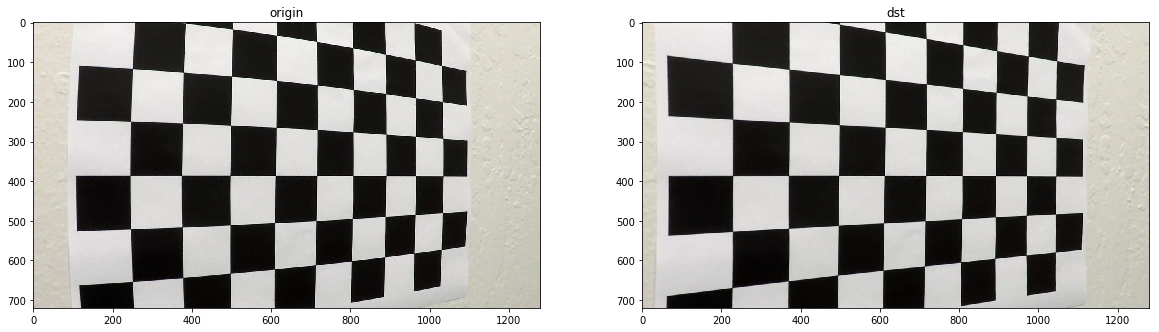

In [16]:
# Find the given objects points and image points

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
     
def cal_undistort(img, objpoints, imgpoints):
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist


### Test undistortion

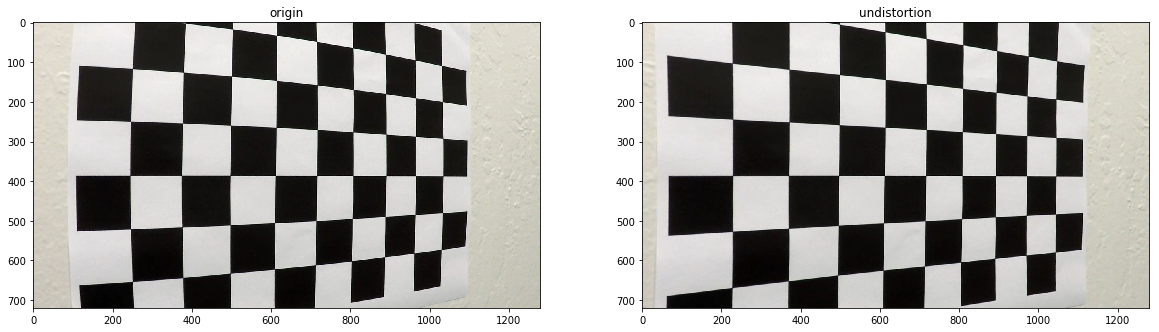

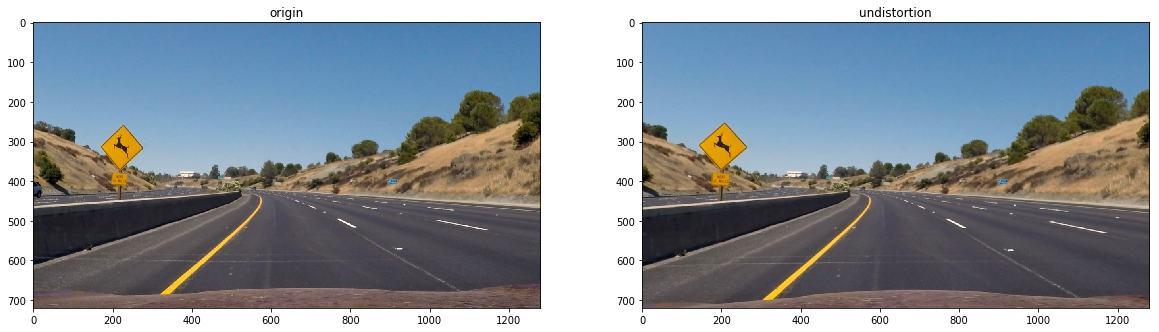

In [24]:

def test_undistort(img):
    dst = cal_undistort(img, objpoints, imgpoints)
    
    plt.figure(figsize=(20,10))
    plt.subplot(121)
    plt.title('origin')
    plt.imshow(img)

    plt.subplot(122)
    plt.title('undistortion')
    plt.imshow(dst)
    plt.show()


timg = mpimg.imread('camera_cal/calibration5.jpg')
test_undistort(timg)

timg = mpimg.imread('test_images/test2.jpg')
test_undistort(timg)


## Gradient threshold

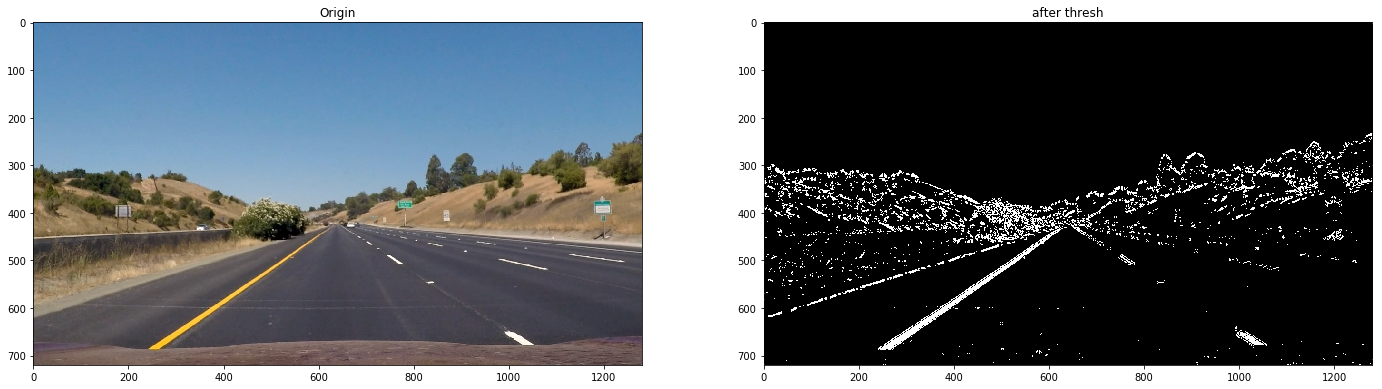

In [3]:
def abs_sobel_thresh(img, orient = 'x', sobel_kernel =3,thresh=(0,255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F,1,0,ksize = sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F,0,1,ksize = sobel_kernel))
    
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0,255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx= cv2.Sobel(gray, cv2.CV_64F,1,0, ksize = sobel_kernel)
    sobely= cv2.Sobel(gray, cv2.CV_64F,0,1, ksize = sobel_kernel)
    
    gradmag = np.sqrt(sobelx ** 2 + sobely ** 2)
    
    scaled_sobel = np.uint8(255*gradmag/np.max(gradmag))    
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    
    return binary_output

def dir_thresh(img, sobel_kernel = 3, dir_thresh= (0,np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx= cv2.Sobel(gray, cv2.CV_64F,1,0, ksize = sobel_kernel)
    sobely= cv2.Sobel(gray, cv2.CV_64F,0,1, ksize = sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output = np.zeros_like(absgraddir)
    binary_output[(absgraddir >= dir_thresh[0]) & (absgraddir <= dir_thresh[1])] = 1
    
    return binary_output


def color_thresh(img,color_thresh=(170,255)):

    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= color_thresh[0]) & (s_channel <= color_thresh[1])] = 1
    
    return s_binary


def combined_thresh(img):
    ksize = 3
    
    gradx = abs_sobel_thresh(img, orient='x',sobel_kernel=ksize, thresh=(20,100))
    grady = abs_sobel_thresh(img, orient='y',sobel_kernel=ksize, thresh=(20,100))
    mag_binary = mag_thresh(img,sobel_kernel=9, mag_thresh=(30,100))
    dir_binary = dir_thresh(img, sobel_kernel=15, dir_thresh = (0.7, 1.3))
    color_binary = color_thresh(img,color_thresh=(170,255))
    
    combined = np.zeros_like(dir_binary)
    combined[((gradx==1) & (grady ==1))|((mag_binary == 1) & (dir_binary ==1)) | (color_binary ==1)]=1
    
    return combined


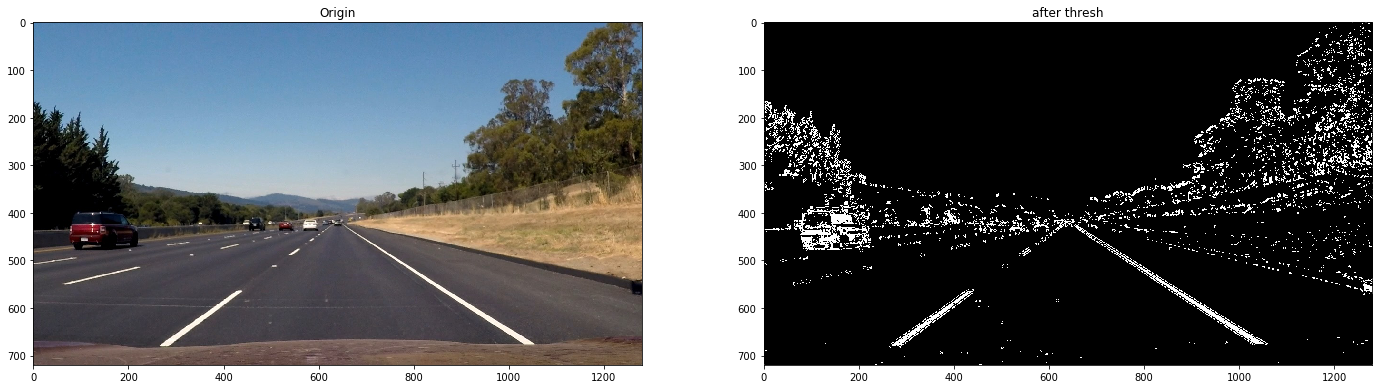

In [29]:
def test_thresh(img):
    comb = combined_thresh(img)

    f,(ax1, ax2) = plt.subplots(1, 2, figsize=(24,9))
    ax1.imshow(timg)
    ax1.set_title('Origin')
    ax2.imshow(comb, cmap='gray')
    ax2.set_title('after thresh')
    plt.show()
    

timg = mpimg.imread('test_images/straight_lines2.jpg')
test_thresh(timg)

## Perspective Transform

In [50]:

def warp_image(img):
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([[585,445],[690,445],[1035,670],[275,670]])
    offset = 200
    dst = np.float32([[offset,0],[img_size[0]-offset,0],[img_size[0]-offset,img_size[1]],[offset,img_size[1]]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    return warped, Minv  

### Test Perspective

In [51]:
# %matplotlib qt4

def test_perspective(img):

    undist= cal_undistort(img, objpoints, imgpoints)
    warped_img, _ = warp_image(undist)
    f,(ax1, ax2) = plt.subplots(1, 2, figsize=(24,9))
    ax1.imshow(timg,cmap='gray')
    ax1.set_title('Undist & Unwarped')
    ax2.imshow(warped_img,cmap='gray')
    ax2.set_title('Warped')
    plt.show()


def perspective_transform(img):
    
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([[585,445],[690,445],[1035,670],[275,670]])
    offset = 200
    dst = np.float32([[offset,0],[img_size[0]-offset,0],[img_size[0]-offset,img_size[1]],[offset,img_size[1]]])
    
    undist= cal_undistort(img, objpoints, imgpoints)
    warped, _ = warp_image(undist)
    
    src_img = img.copy()
    src_pts = src.reshape((-1, 1, 2)).astype("int32")
    cv2.polylines(src_img,[src_pts],True,(255,0,0),thickness = 15)
    
    dst_img = img.copy()
    dst_pts = dst.reshape((-1, 1, 2)).astype("int32")
    cv2.polylines(dst_img,[dst_pts],True,(255,0,0),thickness = 15)
    

    
    f,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,9))
    ax1.imshow(src_img,cmap='gray')
    ax1.set_title('Origin')
    ax2.imshow(dst_img,cmap='gray')
    ax2.set_title('Warped')
    ax3.imshow(warped,cmap='gray')
    ax3.set_title('Bird_view')
    plt.show()
    
    return warped


timg = mpimg.imread('test_images/straight_lines2.jpg')
test_perspective(timg)
perspective_transform(timg)

array([[[74, 71, 78],
        [74, 71, 78],
        [74, 71, 78],
        ..., 
        [93, 87, 87],
        [93, 87, 87],
        [93, 87, 87]],

       [[74, 71, 78],
        [74, 71, 78],
        [74, 71, 78],
        ..., 
        [93, 87, 87],
        [93, 87, 87],
        [93, 87, 87]],

       [[74, 71, 78],
        [74, 71, 78],
        [74, 71, 78],
        ..., 
        [93, 87, 87],
        [93, 87, 87],
        [93, 87, 87]],

       ..., 
       [[64, 61, 70],
        [64, 61, 70],
        [64, 61, 70],
        ..., 
        [74, 68, 70],
        [74, 68, 69],
        [75, 69, 69]],

       [[63, 60, 69],
        [63, 60, 69],
        [63, 60, 69],
        ..., 
        [75, 66, 67],
        [75, 66, 67],
        [78, 69, 70]],

       [[61, 58, 65],
        [62, 59, 66],
        [62, 59, 67],
        ..., 
        [73, 64, 65],
        [74, 65, 66],
        [75, 66, 67]]], dtype=uint8)

## find lines

In [5]:
def find_lane_lines(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
#     print(binary_warped)
#     plt.imshow(binary_warped)
#     print(binary_warped.shape)
#     print(binary_warped)
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
#     plt.plot(histogram)
#     plt.show()
#     print(histogram)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
#     print(out_img)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ################################################
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    
    return ploty, left_fitx, right_fitx

# #     plt.imshow(out_img)
# #     print(out_img.shape)
# #     print(out_img)
#     out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
# #     print(out_img)
#     out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
#     plt.imshow(out_img)
    
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
#     plt.xlim(0, 1280)
#     plt.ylim(720, 0)

    

In [6]:

def find_lines_by_sliding_windows_search(binary_warped):
    #####################################################

    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    #####################################

    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    


In [7]:
def get_measured_curv():
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm')
    return left_curverad,right_curverad

In [8]:
def draw_lines_on_image(warped, undistorted_img, Minv, ploty, left_fitx, right_fitx ):
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undistorted_img.shape[1], undistorted_img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted_img, 1, newwarp, 0.3, 0)
#     plt.imshow(result)
    
    return result
    

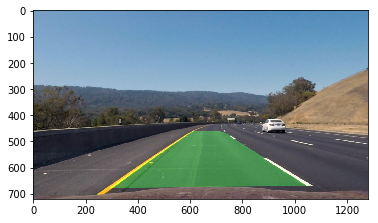

In [9]:
def pipeline(img):
    img = img.copy()
    dst = cal_undistort(img, objpoints, imgpoints)
    comb = combined_thresh(dst)
    warped, Minv = warp_image(comb)
    ploty, left_fitx, right_fitx = find_lane_lines(warped)
# #     lines = find_lines_by_sliding_windows_search(bird_view)
    image_with_lines = draw_lines_on_image(warped, dst, Minv, ploty, left_fitx, right_fitx)
    return image_with_lines

timg = mpimg.imread('test_images/test3.jpg')

# plt.title('origin')
# plt.imshow(timg)

processed_img = pipeline(timg)

plt.imshow(processed_img)

# f,(ax1, ax2) = plt.subplots(1, 2, figsize=(24,9))
# ax1.imshow(timg,cmap='gray')
# ax1.set_title('Origin')
# ax2.imshow(processed_img,cmap='gray')
# ax2.set_title('Warped')

### Run on the test Video

In [10]:
# video_output = 'output_images/project_video_output.mp4'
# clip1 = VideoFileClip('project_video.mp4')
# clip1_output = clip1.fl_image(processed_img)
# %time clip1_output.write_videofile(video_output, audio=False)

video_output = 'output_images/project_video_output.mp4'
clip1 = VideoFileClip('project_video.mp4')
video_clip = clip1.fl_image(pipeline)
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_images/project_video_output.mp4
[MoviePy] Writing video output_images/project_video_output.mp4


100%|█████████▉| 1260/1261 [29:41<00:01,  1.70s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video_output.mp4 

CPU times: user 31min 9s, sys: 14.4 s, total: 31min 24s
Wall time: 29min 45s


In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))